In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Distribution of ER Status:
er_status
0     74
1    198
Name: count, dtype: int64


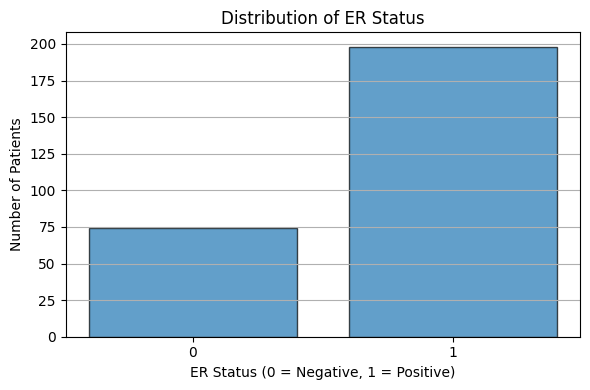

In [6]:
# Load your dataset
df = pd.read_csv('NKI_cleaned.csv')

# Count the number of patients with ER status 0 and 1
er_counts = df['er_status'].value_counts().sort_index()
print("\nDistribution of ER Status:")
print(er_counts)

# Plot bar chart
plt.figure(figsize=(6, 4))
plt.bar(er_counts.index.astype(str), er_counts.values, edgecolor='black', alpha=0.7)
plt.title('Distribution of ER Status')
plt.xlabel('ER Status (0 = Negative, 1 = Positive)')
plt.ylabel('Number of Patients')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Data Quality Check

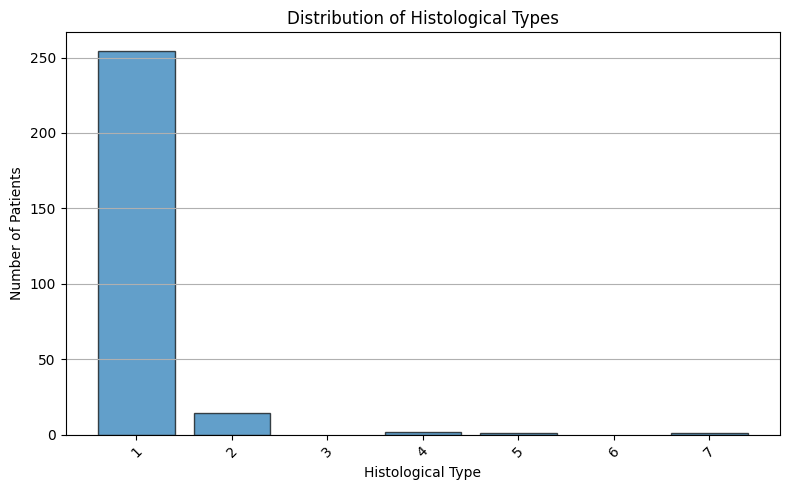

In [14]:
# Count occurrences of each histtype
hist_counts = df['histtype'].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(hist_counts.index, hist_counts.values, edgecolor='black', alpha=0.7)
plt.title('Distribution of Histological Types')
plt.xlabel('Histological Type')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)  # rotate if labels are long
plt.tight_layout()
plt.grid(axis='y')
plt.show()


PENDING: Perform histtype analysis to check what each number means

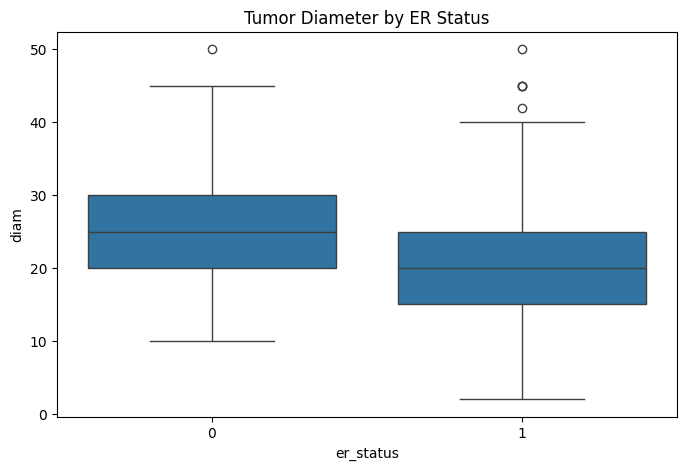

In [19]:
# TRY TO SEE IF SIZE OF THE TUMOR IS CORRELATED TO ER STATUS (+ OR -)
plt.figure(figsize=(8,5))
sns.boxplot(x='er_status', y='diam', data=df)
plt.title('Tumor Diameter by ER Status')
plt.show()

Event indicator counts:
 eventdeath
0    195
1     77
Name: count, dtype: int64

Event indicator proportions:
 eventdeath
0    0.716912
1    0.283088
Name: proportion, dtype: float64


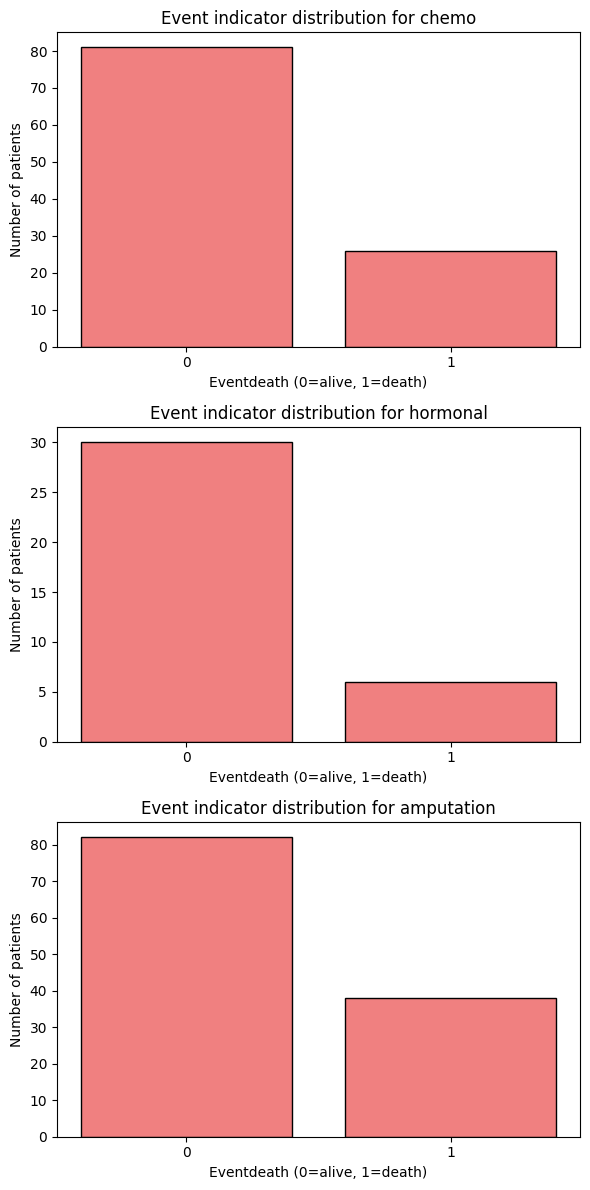

In [20]:
# CHECK EVENDEATH IMBALANCE
counts = df['eventdeath'].value_counts().sort_index()
proportions = df['eventdeath'].value_counts(normalize=True).sort_index()

print("Event indicator counts:\n", counts)
print("\nEvent indicator proportions:\n", proportions)

treatment_columns = ['chemo', 'hormonal', 'amputation']
fig, axs = plt.subplots(len(treatment_columns), 1, figsize=(6, 4*len(treatment_columns)))

for ax, col in zip(axs, treatment_columns):
    subset = df[df[col] == 1]
    counts = subset['eventdeath'].value_counts().sort_index()
    
    ax.bar(counts.index.astype(str), counts.values, color='lightcoral', edgecolor='k')
    ax.set_title(f'Event indicator distribution for {col}')
    ax.set_xlabel('Eventdeath (0=alive, 1=death)')
    ax.set_ylabel('Number of patients')

plt.tight_layout()
plt.show()

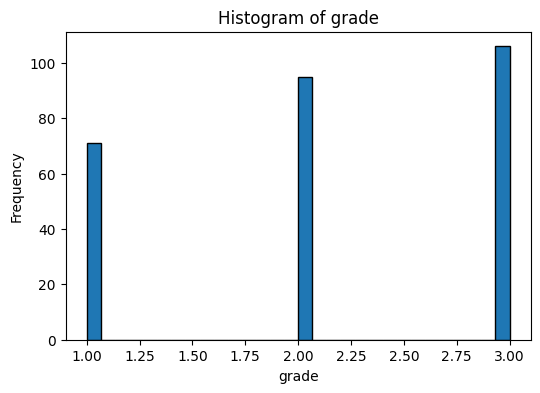

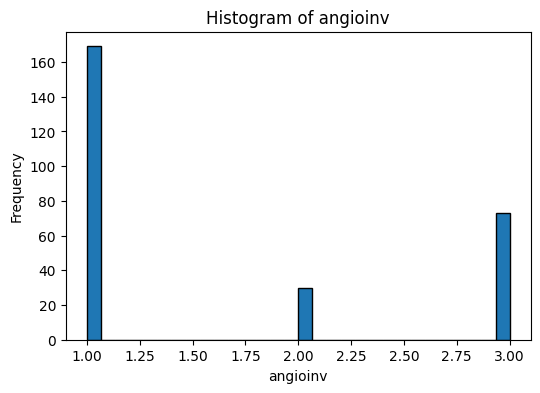

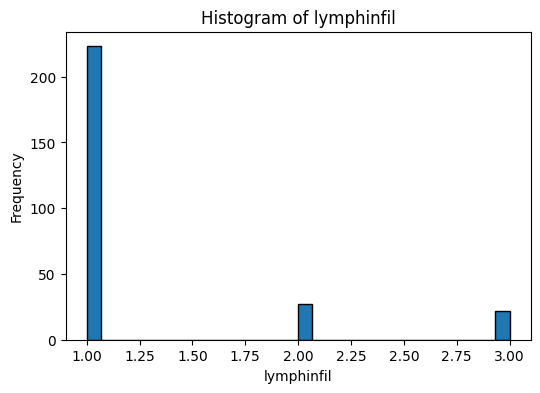

In [21]:
# CHECK GRADE, ANGIOINV, AND LYMPHINFIL DISTRIBUTION

numeric_cols = ['grade', 'angioinv', 'lymphinfil']

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=30, edgecolor='k')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

FEATURE ENGINEERING

In [22]:
# Drop indentificators
df = df.drop(['Patient', 'ID', 'barcode'], axis=1)

# Based on the imbalance between histtype 1 (250) and others (20),
# I decided to do a binary separation
df['histtype_is_1'] = (df['histtype'] == 1).astype(int)
df = df.drop(['histtype'], axis=1)

I am wondering about the possibility of leaving "grade" as an ordinal numeric variable or to one-hot encode it, 
so I will use Kaplan-Meier estimator to see if the type of grade has a linear behaviour

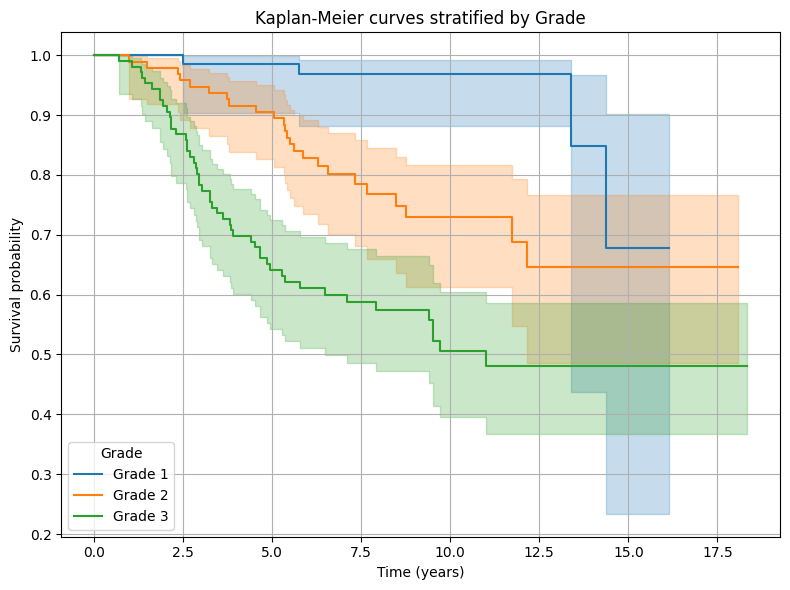

In [23]:
# I am wondering about the possibility of leaving "grade" as an ordinal numeric variable
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))

for grade_level in sorted(df['grade'].unique()):
    mask = df['grade'] == grade_level
    kmf.fit(df.loc[mask, 'survival'], event_observed=df.loc[mask, 'eventdeath'], label=f'Grade {grade_level}')
    kmf.plot_survival_function()

plt.title('Kaplan-Meier curves stratified by Grade')
plt.xlabel('Time (years)')
plt.ylabel('Survival probability')
plt.legend(title='Grade')
plt.grid(True)
plt.tight_layout()
plt.show()


The curves appear to show a gradual, ordered trend, survival decreases progressively from grade 1 → 2 → 3, 
and the lines don’t cross or show abrupt non-linear jumps. So it’s reasonable to keep grade as an ordinal 
numeric variable (1, 2, 3). There’s no obvious evidence suggesting I need to one-hot encode 
grades separately.

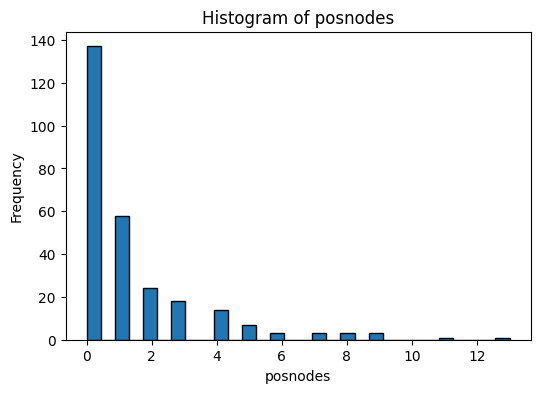

In [24]:
# CHECK POSNODES DISTRIBUTION
plt.figure(figsize=(6,4))
plt.hist(df['posnodes'].dropna(), bins=30, edgecolor='k')
plt.title('Histogram of posnodes')
plt.xlabel('posnodes')
plt.ylabel('Frequency')
plt.show()

The original posnodes variable, representing the number of positive lymph nodes, showed a highly right-skewed 
distribution with most patients having 0–1 nodes and a long tail of higher counts. This skew can violate linearity 
assumptions in survival models and lead to unstable estimates.

To address this, I applied a log transformation using log1p (log(x + 1)) to compress the range of values and 
reduce the impact of extreme outliers. After inspecting the histogram of log_posnodes, the transformed distribution 
is more compact and suitable for modeling, while retaining important information about variation in node involvement.

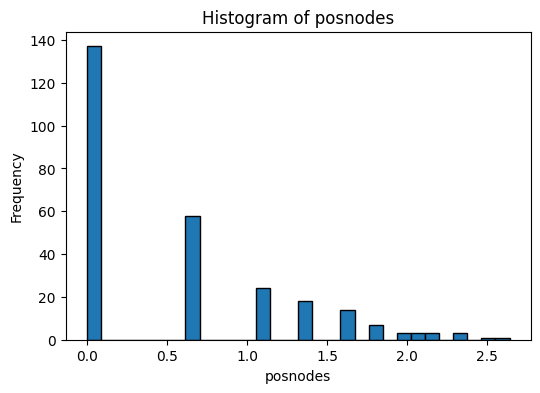

In [25]:
df['posnodes'] = np.log1p(df['posnodes'])

# CHECK LOG_POSNODES DISTRIBUTION
plt.figure(figsize=(6,4))
plt.hist(df['posnodes'].dropna(), bins=30, edgecolor='k')
plt.title('Histogram of posnodes')
plt.xlabel('posnodes')
plt.ylabel('Frequency')
plt.show()

We standardized the continuous variables age and diam by transforming them to have a mean of 0 and a standard deviation 
of 1. Standardization is a common preprocessing step that improves numerical stability and helps many modeling methods, 
including linear models (e.g., Cox regression), regularized models, and neural networks — by ensuring that all features 
contribute on a comparable scale. This prevents features with larger numerical ranges from disproportionately influencing 
the model, leading to better convergence, more interpretable coefficients, and often improved predictive performance.

EXPLORATORY SURVIVAL ANALYSIS

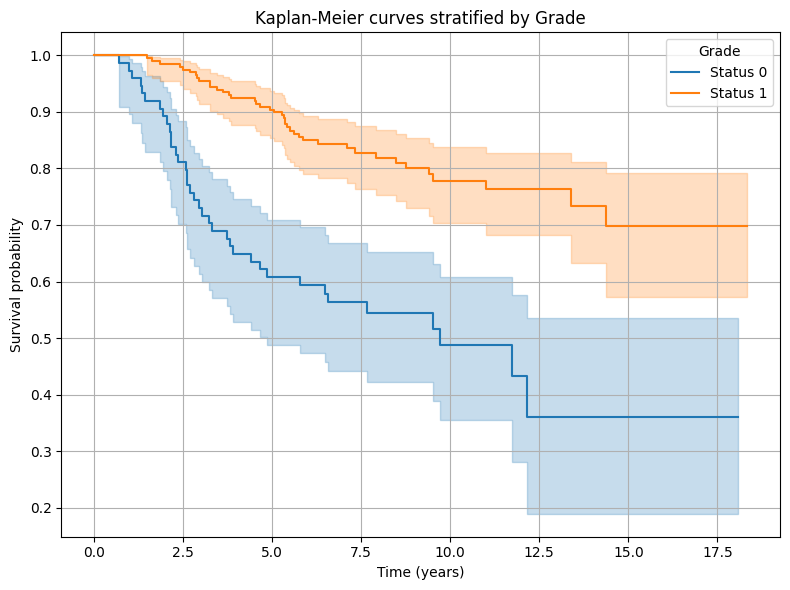

In [26]:
plt.figure(figsize=(8,6))

for grade_level in sorted(df['er_status'].unique()):
    mask = df['er_status'] == grade_level
    kmf.fit(df.loc[mask, 'survival'], event_observed=df.loc[mask, 'eventdeath'], label=f'Status {grade_level}')
    kmf.plot_survival_function()

plt.title('Kaplan-Meier curves stratified by Grade')
plt.xlabel('Time (years)')
plt.ylabel('Survival probability')
plt.legend(title='Grade')
plt.grid(True)
plt.tight_layout()
plt.show()

It is observed that the ER status (wheter is + or -) plays an important role in determining the survival time
of the patients. The trend suggests that ER+ patients are more likely to survive longer than those with ER-.

In [31]:
print(df.head(1))
df.to_csv('feature_engineered_df.csv', index=False)

   age  eventdeath   survival  timerecurrence  chemo  hormonal  amputation  \
0   43           0  14.817248       14.817248      0         0           1   

   diam  posnodes  grade  angioinv  lymphinfil  er_status  histtype_is_1  
0    25       0.0      2         3           1          1              1  


MODELLING CONTINUES IN THE OTHER NOTEBOOK